## Project Preparation 

In [21]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import requests
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts
from datetime import datetime, timedelta
from itertools import combinations
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import yfinance
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")


### Dynamic stock data fetcher

Stock fetcher extracts the current Wikipedia list of all S&P 500 companies


In [2]:

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    html = requests.get(url).content
    df_list = pd.read_html(html)
    
    # The relevant table containing S&P 500 information is typically the first one
    sp500_table = df_list[0]
    
    # Extracting the columns of interest
    sp500_data = sp500_table[['Symbol', 'Security']]
    
    return sp500_data

# Call the function to get the S&P 500 data
sp500_data = get_sp500_tickers()
companies_dict = sp500_data.set_index('Symbol').to_dict()['Security']

# Display the data
print(len(companies_dict))
tickers = list(companies_dict.keys())


503


### Data wrangling

Exploring the data, preparing it and cleaning it

In [3]:
# Reading data from the given csv file
data = pd.read_csv('SP500_prices.csv')

# Data cleaning - removing columns with company names not in S&P 500
for c in data.columns[1:]:
    if c not in tickers:
        data = data.drop([c], axis=1)

# Data cleaning - datatype conversion and date filtering
data.date = pd.to_datetime(data.date)
data = data[data.date > "2018"][data.date < "2022"]
data.index = data["date"]
data.drop(columns=["date"],inplace=True)        

Analysis will be conducted on daily returns

In [4]:
returns_1_day = data.pct_change()

# Removing the first row of NaN values due to pct_change functio
returns_1_day = returns_1_day.iloc[1:,:]

# Check for missing values in returns_1_day
missing_values = returns_1_day.isnull().sum()

# Display columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]

# Print missing vlues in csv file
# missing_values.to_csv('missing.csv')

# As we can see, there are columns with missing values, we will drop them
returns_1_day.dropna(axis=1,inplace=True)

Let us print out two stocks that have historically performed similarly (just by trying out couple pairs)

For clustering we need to change our dataframe to be suitable to our algorithms

In [5]:
ret_T = returns_1_day.T

ret_T = pd.DataFrame(ret_T)
ret_T.index.name = 'stock'

To optain the right amount of dumentionality reduction without looksing too much variance/information we will use the pareto principal

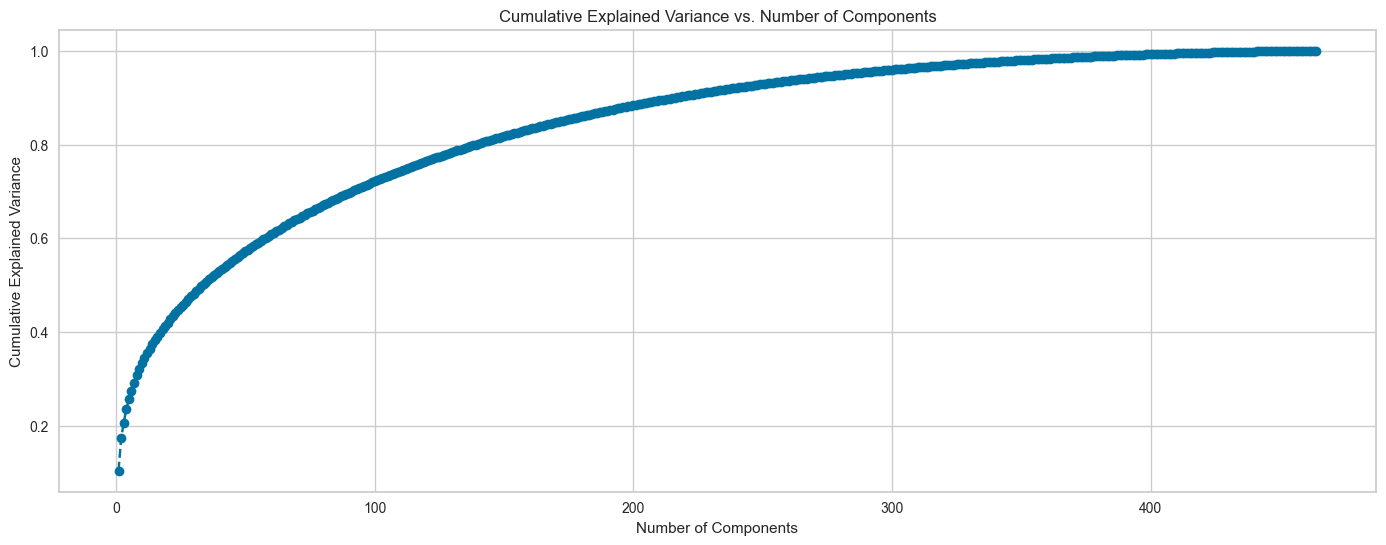

91 components needed to explain 70% of the variance
139 components needed to explain 80% of the variance
216 components needed to explain 90% of the variance


In [6]:
# Standardize the Data improve the robustness and performance of your models 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ret_T)

# PCA Dimensionality Reduction
pca = PCA(random_state=1)
pca.fit(scaled_data)

# Plot explained variance ratio to decide on the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(17, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Check the number of components needed to explain 70% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.7:
        print(str(i) + " components needed to explain 70% of the variance")
        break

# Check the number of components needed to explain 80% of the variance <-- we choose this as the pareto optimum component
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.8:
        print(str(i) + " components needed to explain 80% of the variance")
        n_components = i
        break

# Check the number of components needed to explain 90% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.9:
        print(str(i) + " components needed to explain 90% of the variance")
        break

Do the PCA and print out our new dataframe with a component reduction of >60%

In [7]:
pca = PCA(n_components=n_components, random_state=1)
principal_components = pca.fit_transform(scaled_data)

# principal_components as a dataframe
principal_components = pd.DataFrame(principal_components)

print("Shape of principal_components: " + str(principal_components.shape))


Shape of principal_components: (464, 139)


## Clustering Analysis

[...] The final method of choice, after conducting a rudimentary heatmap and full KMeans clustering, is DBSCAN

In [8]:
eps_value = 15
min_samples_value = 5

clf = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clf.fit(principal_components)

# Extract cluster labels and remove noise points
labels = clf.labels_
clustered_mask = (labels != -1)
# print(clustered_mask)
clustered_data = principal_components[clustered_mask]
clustered_labels = labels[clustered_mask]

# Calculate the number of clusters (excluding noise)
n_clusters_ = len(set(clustered_labels))
# Calculate the number of noise points
n_noise_ = len(labels) - len(clustered_data)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Calculate silhouette score for clustered data
silhouette_avg = metrics.silhouette_score(clustered_data, clustered_labels)
print(f"Silhouette Coefficient (excluding noise): {silhouette_avg:.3f}")

Estimated number of clusters: 3
Estimated number of noise points: 333
Silhouette Coefficient (excluding noise): 0.216


Silhouette Coefficient is already quite good but lets try to improve it by tuning the hyperparameters! 
We also init couple basic conditions

In [9]:

# Range of eps and granuality
eps_values = np.arange(5, 30, 0.1)

# Minimum Samples per Cluster
min_samples_values = list(range(3, 10))  

# Restirctions for Clusters
min_num_clusters = 4
min_num_stocks = 120

best_eps = None
best_min_samples = None
best_silhouette_score = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        clf = DBSCAN(eps=eps, min_samples=min_samples)
        labels = clf.fit_predict(principal_components)
        unique_labels = set(labels)

        if len(unique_labels) <= min_num_clusters or len([label for label in labels if label != -1]) <= min_num_stocks:  
            pass
        else:
            clustered_mask = (labels != -1)
            clustered_data = principal_components[clustered_mask]
            clustered_labels = labels[clustered_mask]

            # Calculate silhouette score
            silhouette_avg = metrics.silhouette_score(clustered_data, clustered_labels)

            # Update best parameters if silhouette score is higher
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_silhouette_score}")

# Fit DBSCAN with best parameters
best_clf = DBSCAN(eps=best_eps, min_samples=best_min_samples)

best_labels = best_clf.fit_predict(principal_components)
n_clusters_ = len(set(best_labels)) - (1 if -1 in best_labels else 0)

clustered = best_clf.labels_


best_clustered_mask = (best_labels != -1)
best_clustered_data = principal_components[best_clustered_mask]
best_clustered_labels = best_labels[best_clustered_mask]

n_noise_ = list(best_labels).count(-1)

clustered_series = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1)]

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"Silhouette Coefficient: {best_silhouette_score:.3f}")


Best eps: 13.29999999999997
Best min_samples: 3
Best Silhouette Score: 0.3324422717886806
Estimated number of clusters: 17
Estimated number of noise points: 337
Silhouette Coefficient: 0.332


Let us visualize the clusters we just created

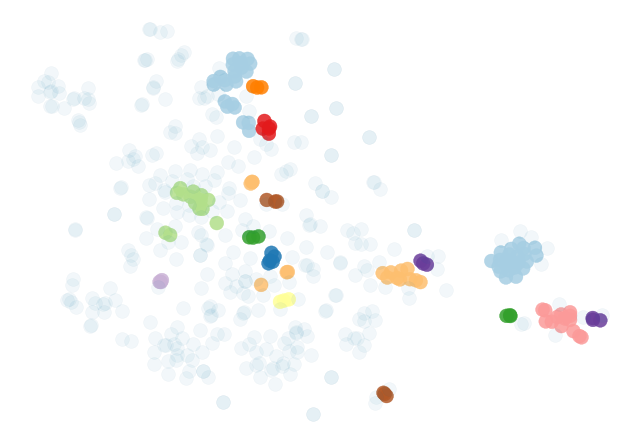

In [10]:
plt.figure(1, facecolor='white')
plt.clf()
tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1)
tsne_result = tsne.fit_transform(principal_components)


plt.scatter(
    tsne_result[(clustered!=-1), 0],
    tsne_result[(clustered!=-1), 1],
    s=100,
    alpha=0.85,
    c=clustered[clustered!=-1],
    cmap=cm.Paired
)

plt.scatter(
    tsne_result[(clustered_series_all==-1).values, 0],
    tsne_result[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

#plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted')
plt.axis("off")
plt.savefig('DBSCAN_cluster.svg',format='svg', bbox_inches='tight')
plt.show()

# print(tsne_result)


And also print out the names of the clusters

In [11]:
DBSCAN_cluster =[]
# print out the stock names that are in each cluster
for i in range(len(ticker_count_reduced)):
    print("Cluster " + str(i+1) + " (" + str(len(clustered_series[clustered_series==i])) + " stocks)")
    for name in clustered_series[clustered_series==i].index:
        print(companies_dict[name], end=", ")
        DBSCAN_cluster.append({"Cluster": i,"Stock":name,"Stock_Name":companies_dict[name]})
    print("\n")

Cluster 1 (23 stocks)
Ameren, American Electric Power, Atmos Energy, American Water Works, CMS Energy, Dominion Energy, DTE Energy, Duke Energy, Consolidated Edison, Eversource, Entergy, Evergy, Exelon, Alliant Energy, NextEra Energy, NiSource, Public Service Enterprise Group, Pinnacle West, PPL Corporation, Southern Company, Sempra Energy, WEC Energy Group, Xcel Energy, 

Cluster 2 (23 stocks)
Aflac, Ameriprise Financial, Bank of America, Citigroup, Citizens Financial Group, Comerica, Fifth Third Bank, Globe Life, Goldman Sachs, Huntington Bancshares, JPMorgan Chase, KeyCorp, Loews Corporation, MetLife, Morgan Stanley, M&T Bank, Principal Financial Group, PNC Financial Services, Prudential Financial, Regions Financial Corporation, Truist, U.S. Bank, Zions Bancorporation, 

Cluster 3 (5 stocks)
Arthur J. Gallagher & Co., Aon, Brown & Brown, Marsh McLennan, Willis Towers Watson, 

Cluster 4 (14 stocks)
Ametek, Amphenol, Dover Corporation, Emerson Electric, Eaton Corporation, Fortive, Ho

## Pair Selection

Init pair selection parameters

In [12]:
# Minimum correlation
min_corr = 0.9

# Max p-value to dismiss the h0-hypothesis in the cointegration test
pmax_coint = 0.05

# Max p-value to dismiss the h0-hypothesis in the augmented Dickey-Fuller test
pmax_adf = 0.05

# Max number of stock pairs to consider in the portfolio
max_quantity_pairs = 20

# Consider cluster from DBSCAN and consider train data for the pair selection
selected_clusters = pd.DataFrame(DBSCAN_cluster.copy())
train_data = data.copy()

# Filter the DataFrame based on the tickers in the specified cluster
selected_data = train_data[selected_clusters["Stock"]]

### Pair Validation
We check the identified clusters for stock pairs. In order to be considered as a pair, the following hypothese have to be met:   
    1. Correlation of stock price evolution of 95% or higher (and different to 1)  
    2. Check if the Cointegration hypothesis ho is dismissed  
    3. Check if the Augmented Dickey-Fuller hypothesis ho is dismissed 

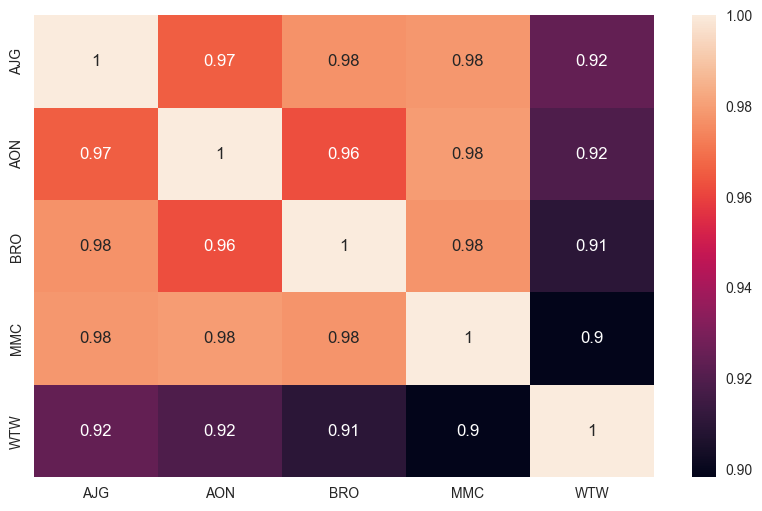

In [13]:
# Correlation test for the remaining stocks
corr = selected_data.corr()

# We investigate the correlation within a single cluster
cluster_to_investigate =2
cluster_stocks= selected_clusters[selected_clusters["Cluster"]==cluster_to_investigate]
plt.figure(figsize=(10, 6))
sns.heatmap(selected_data[cluster_stocks["Stock"]].corr(), annot=True)
plt.savefig(f'Correlation_Cluster_{cluster_to_investigate}.png',format='png', bbox_inches='tight')
plt.show()


#We also want to create a table giving us the KPIs of each pair
cluster_oversight =set()
for pair in combinations(selected_clusters.loc[selected_clusters["Cluster"] == cluster_to_investigate, "Stock"], 2):
        stock1, stock2 = pair
        # Correlation
        correlation = corr[stock1][stock2]
        #Cointegration
        coint = sm.tsa.coint(selected_data[stock1], selected_data[stock2])
        # Augmented Dickey-Fuller Test
        first_ADF = adfuller(selected_data[stock1])                             # Stationarity of stock 1
        second_ADF = adfuller(selected_data[stock2])                            # Stationarity of stock 2
        Spread_ADF = adfuller(selected_data[stock1] - selected_data[stock2])    # Stationarity of the spread between stock 1 and 2
        Ratio_ADF = adfuller(selected_data[stock1] / selected_data[stock2])     # Stationarity of the ratio of stock 1 and 2
        
        # We save the correlation as well as the p-values of the cointegration and the ADF
        cluster_oversight.add((stock1, stock2, correlation,coint[1],first_ADF[1],second_ADF[1],Spread_ADF[1],Ratio_ADF[1]))

cluster_oversight = pd.DataFrame(cluster_oversight, columns=["Stock 1","Stock 2","Correlation","Cointegration","ADF Stock 1","ADF Stock 2","ADF Spread","ADF Ratio"])
# cluster_oversight.to_excel("ClusterOversight.xlsx", index = False)

In [14]:
# Now we apply our heuristics all clusters to identify all potential stock pairings
eligible_pairs_list = set()

for cluster in selected_clusters["Cluster"].unique():
    for pair in combinations(selected_clusters.loc[selected_clusters["Cluster"] == cluster, "Stock"], 2):
        # Find pair 
        stock1, stock2 = pair

        # Determine correlation value
        correlation = corr[stock1][stock2]
        
        # Check if Correlation is significant
        # Note: Dismiss correlation equal to 1 since this is realisticly only possible between the same stock
        if correlation > min_corr and correlation != 1:
            coint = sm.tsa.coint(selected_data[stock1], selected_data[stock2])
        
            # Check if the cointegration test is significant
            if coint[1] <= pmax_coint:

                # Augmented Dickey-Fuller Test
                first_ADF = adfuller(selected_data[stock1])                             # Stationarity of stock 1
                second_ADF = adfuller(selected_data[stock2])                            # Stationarity of stock 2
                Spread_ADF = adfuller(selected_data[stock1] - selected_data[stock2])    # Stationarity of the spread between stock 1 and 2
                Ratio_ADF = adfuller(selected_data[stock1] / selected_data[stock2])     # Stationarity of the ratio of stock 1 and 2

                # In the end we consider the ratio for our strategy, therefore we take the corresponding ADF test into account
                if Ratio_ADF[1] <= pmax_adf:
                    # Add pair to list
                    eligible_pairs_list.add((stock1, stock2, correlation,coint[1],Ratio_ADF[1]))

### Ranking potential pairs
We try to rank the remaining pairs now by the chance, that they are eligible for the pairs trading hypothesis. In order to make this ranking we consider following weight function:

$ Chance_{eligible} = (1-p_{coint}) *(1-p_{ADF})$

In [15]:
# Sort identified pairs by their test results
sorted_eligible_pairs = sorted(eligible_pairs_list, key=lambda x: (1-x[3])*(1-x[4]), reverse=True)

# Create a DataFrame to store informations
sorted_eligible_pairs_df = pd.DataFrame(sorted_eligible_pairs, columns=['Stock_1', 'Stock_2', 'Correlation', 'Cointegration','Ratio_ADF'])

# In case of too many pairs we select n pairs to our convenience
selected_pairs = sorted_eligible_pairs[:max_quantity_pairs]

# Print the selected pairs
print("\nA total of "+str(len(sorted_eligible_pairs))+" pairs have been found.")
print(f"A total of {len(selected_pairs)} were selected.")
sorted_eligible_pairs_df[:max_quantity_pairs]



A total of 22 pairs have been found.
A total of 20 were selected.


,Stock_1,Stock_2,Correlation,Cointegration,Ratio_ADF
0,DTE,PEG,0.967359,0.000884,0.000293
1,AWK,NEE,0.986857,0.002170,0.000479
2,ES,WEC,0.980518,0.002446,0.000846
3,AEP,SRE,0.936276,0.004734,0.000967
4,CFG,RF,0.982315,0.013899,0.000639
5,PG,VRSK,0.964591,0.013567,0.001912
6,JPM,MET,0.968502,0.013916,0.004255
7,BAC,PNC,0.984833,0.017393,0.001535
8,PFG,PNC,0.926320,0.013519,0.005605
9,PFG,TFC,0.920864,0.023309,0.002554


### Pair Visualization
We reeintroduce the visualization through TSNE in order to inspect the chosen pairs.  
Note that the visualization in 2D thorugh TSNE might not reflect the conclusion that DBSCAN or the hypothesis tests  have made before

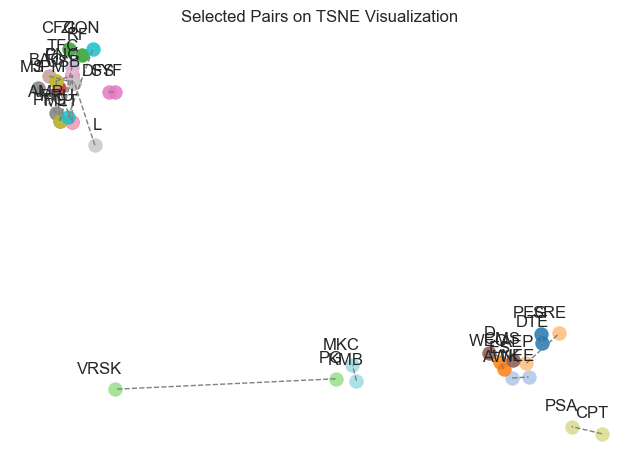

In [16]:
#Build DataFrame which collects all TSNE results from concerned stocks
tsne_selected = []
for x,y in ([row[0],row[1]] for row in selected_pairs):
    tsne_selected.append([x,tsne_result[ret_T.index.get_loc(x),0],tsne_result[ret_T.index.get_loc(x),1]])
    tsne_selected.append([y,tsne_result[ret_T.index.get_loc(y),0],tsne_result[ret_T.index.get_loc(y),1]])

# Convert the list to a set to get unique elements based on the first element of each sub-list
tsne_selected = {tuple(row) for row in tsne_selected}
tsne_selected = list(tsne_selected)
tsne_selected = pd.DataFrame(tsne_selected, columns =["Stock","x","y"])


# Define a color map
color_map = cm.get_cmap('tab20')

# Connect datapoints with lines based on top_10_pairs
for index,pair in enumerate(selected_pairs):
    x1, y1 = tsne_selected.loc[tsne_selected["Stock"] == pair[0], ["x", "y"]].values.flatten()
    x2, y2 = tsne_selected.loc[tsne_selected["Stock"] == pair[1], ["x", "y"]].values.flatten()

    color = color_map(index / len(selected_pairs))
    plt.scatter(x1, y1, s=100, alpha=0.85, label="Stocks", color=color)
    plt.scatter(x2, y2, s=100, alpha=0.85, label="Stocks", color=color)
    plt.plot([x1, x2], [y1, y2], color="grey", linestyle='--', linewidth=1)

# Annotate each point with its label
for index, row in tsne_selected.iterrows():
    plt.annotate(row["Stock"], (row["x"], row["y"]+1), textcoords="offset points", xytext=(5,5), ha='right')

# Customize the plot as needed
plt.title('Selected Pairs on TSNE Visualization')
plt.axis("off")

# Show the plot
plt.show()


## Trading Strategy
There are plenty of parameters that can be adjusted in order to align the strategy with users chosen risk management. They can be set up here and alternate the buying heuristics
  
Z-Scores

Init trading parameters

In [17]:
# Time frames (trading days) to consider while defining the z-score
time_for_average = 60      # (Rolling) days to consider for the average
time_for_x = 1         # (Rolling) days to consider for x

# Z-scores where the trades are introduced
# Note: this value is considered in both directions 
# ( e.g. the trades for start_z = 1 are made at 1 and minus 1)
start_z = 1.645

# Z-scores where the trades are closed
# Note: the sign is considered relative to the upper z  
# ( e.g. start_z = 1  and end_z = -1: a trade is started at one and closed at -1, the inverse starts at -1 and closes at 1 )
end_z = -0.25


Risk Management

In [18]:
# Maximum numbers of active trades within one pair
quantity_limit = 50

# Maximum numbers of trading days that a pair can be hold
time_limit = 126

# Z-Score, where the trades are stopped in order to cut losses
z_limit = 6 

Order fees

In [19]:
# Trade volume: Money that is spent per signal
# (e.g. long stock 1 with trade volume and short stock 2 with trade volume )
trade_volume = 500

# Order fees per transaction
# Assume Trade Republic fees of one euro
orderfeeabs = 1

# Traxes on capital gains
# Assume German tax rates
taxes = 0.26375

### Data Sourcing
To able to evaluate the stocks performances till the current day, we need to get the evolution of stock prices from the end of our training time frame till today. In order to access these informations, we source the data of our chosen stocks from yahoo finance. The adjusted close is in this case the correct stock price for each daay, since the avavlable training data corresponds to it as well

In [22]:

unique_pair = []
for pair in selected_pairs:
    if pair[0] not in unique_pair:
        unique_pair.append(pair[0])
    if pair[1] not in unique_pair:
        unique_pair.append(pair[1])
stock_df_top_pairs = pd.DataFrame(yfinance.download(unique_pair, start="2022-01-02",end="2023-12-31")["Adj Close"])

[*********************100%%**********************]  33 of 33 completed


### Generation of tickers
We now investigate on the test data. First of all, we determine the z-score for the current price ratio and the rolling average of 60 days for the longtime. This enables us to evaluate the score with rather relevant than historic data. We then define our buy and sell signals and visualize them in a plot.

$ Z = \dfrac{x-\bar x_{60 Days}}{\sigma _{60 Days}}$

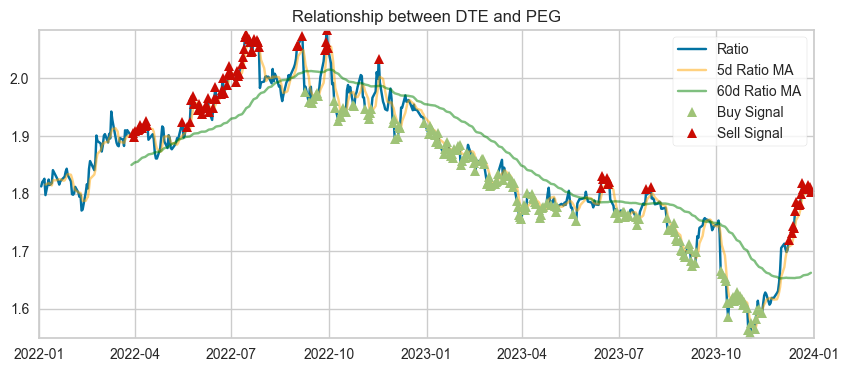

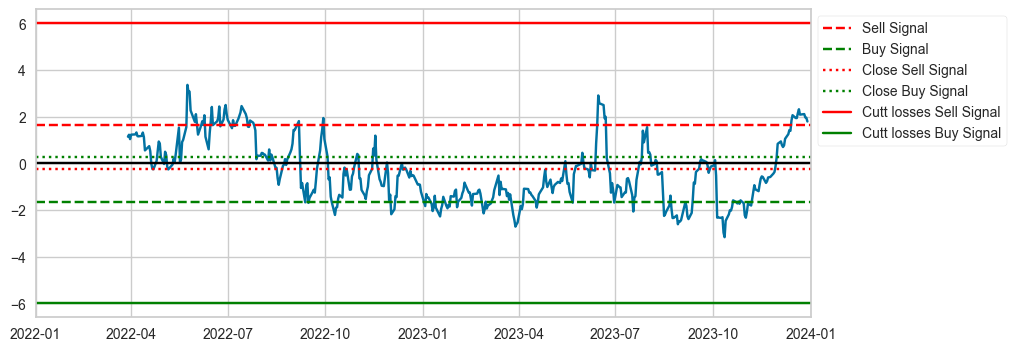

In [23]:
for pair in selected_pairs:

    stock_1 = stock_df_top_pairs[pair[0]]
    stock_2 = stock_df_top_pairs[pair[1]]

    # Define ratio of the pair
    ratio = stock_1 / stock_2

    # Determine rolling averages of 5 and 60 days
    ratio_mavg_5 = ratio.rolling(window= 5, center=False).mean()
    ratio_mavg_60 = ratio.rolling(window= 60, center=False).mean()

    # Determine Z-score
    ratio_z = ratio.rolling(window= time_for_x, center=False).mean()
    ratio_mavg_z = ratio.rolling(window= time_for_average, center=False).mean()
    std_z = ratio.rolling(window=time_for_average, center=False).std()
    zscore = (ratio_z - ratio_mavg_z)/std_z

    # Create signals, where stock_1 is bought and sold (and stock_2 vice versa) 
    buy = ratio.copy()
    sell = ratio.copy()
    buy[:time_for_average]= np.nan
    sell[:time_for_average]= np.nan
    buy[zscore>-1] = np.nan
    sell[zscore<1] = np.nan


    # Plot ratio with signals
    plt.figure(figsize=(10, 4))
    plt.plot(ratio,  label="Ratio")
    plt.plot(ratio_mavg_5, c = 'orange', alpha = 0.5,  label="5d Ratio MA")
    plt.plot(ratio_mavg_60, c = 'green', alpha = 0.5,  label="60d Ratio MA")
    plt.plot(buy, color='g', linestyle='None', marker='^',  label="Buy Signal")
    plt.plot(sell, color='r', linestyle='None', marker='^',  label="Sell Signal")
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, ratio.min(), ratio.max()))
    plt.legend(frameon=True, facecolor='white')
    plt.title(f'Relationship between {pair[0]} and {pair[1]}')
    plt.xlim(datetime(2022,1,1),datetime(2024,1,1))
    plt.show()

    # Plot Z-Score with relevant frontiers
    plt.figure(figsize=(10, 4))
    plt.plot(zscore)
    plt.axhline(0, color='black')
    plt.axhline(start_z, color='red', linestyle='--', label = "Sell Signal")
    plt.axhline(-start_z, color='green', linestyle='--', label= "Buy Signal")
    plt.axhline(end_z, color='red', linestyle='dotted', label="Close Sell Signal")
    plt.axhline(-end_z, color='green', linestyle='dotted', label="Close Buy Signal")
    plt.axhline(z_limit, color='red', linestyle='solid', label= "Cutt losses Sell Signal")
    plt.axhline(-z_limit, color='green', linestyle='solid', label= "Cutt losses Buy Signal")
    plt.xlim(datetime(2022,1,1),datetime(2024,1,1))
    plt.legend(frameon=True, facecolor='white',loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    break

In [24]:
# Trading strategy
trade_list = pd.DataFrame(columns=['StartDate','LongStock','LongStartPrice','ShortStock','ShortStartPrice','ClosingDate','LongClosingPrice','ShortClosingPrice','ClosingCount','Status'])
number_of_trading_days = len(zscore) - 1
test= ""
for pair in selected_pairs:
    stock_1 = stock_df_top_pairs[pair[0]]
    stock_2 = stock_df_top_pairs[pair[1]]
    ratio = stock_1 / stock_2

    # Determine Z-score
    ratio_z = ratio.rolling(window=time_for_x, center=False).mean()
    ratio_mavg_z = ratio.rolling(window=time_for_average, center=False).mean()
    std_z = ratio.rolling(window=time_for_average, center=False).std()
    zscore = (ratio_z - ratio_mavg_z)/std_z

    for day, zscore_value in enumerate(zscore):
        # Check strategy of long stock 1 and short stock 2 
        if zscore_value < -start_z : # Open trade
            if len(trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open')]) < quantity_limit:
                new_row = pd.DataFrame({'StartDate':[day],'LongStock':[pair[0]],'LongStartPrice':[stock_1.iloc[day]],'ShortStock':[pair[1]],
                                        'ShortStartPrice':[stock_2.iloc[day]],'Status':['open'],'ClosingDate':['open'],'LongClosingPrice':['open'],'ShortClosingPrice':['open'],'ClosingCount':[0]})
                trade_list = pd.concat([trade_list, new_row], ignore_index=True)
        # Check z-score to see if the trades need to be closed

        if zscore_value > -end_z: # close trades
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_1.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_2.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'Status'] = 'Normally closed'
       
        if zscore_value < -z_limit: # Risk Management: close trades, because z-score is to big and correlation doesnt seem to exist anymore -> risk management
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_1.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_2.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed due to z limit'
            print("Risk Management: ", pair[1], "&", pair[0], "will be removed from the trading plan. The Z-score exceed risk limitations")
            break

        # Risk Management : Close trades that are older than the maximal accepted period
        trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'ClosingDate']= day
        trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'LongClosingPrice']= stock_1.iloc[day]
        trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'ShortClosingPrice']= stock_2.iloc[day]
        trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'Status'] = 'closed due to time limit'
        
        # Stop trading that pair in case of risk management application
        if not trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'closed due to time limit')].empty:
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_1.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_2.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed due to time limit'
            print("Risk Management: ", pair[0], "&", pair[1], "will be removed from the trading plan. The max holding period was exceeded.")
            break

        # Check strategy of long stock 1 and short stock 2 
        if zscore_value > start_z : # Open trade
            if len(trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open')]) < quantity_limit:
                new_row = pd.DataFrame({'StartDate':[day],'LongStock':[pair[1]],'LongStartPrice':[stock_2.iloc[day]],'ShortStock':[pair[0]],
                                        'ShortStartPrice':[stock_1.iloc[day]],'Status':['open'],'ClosingDate':['open'],'LongClosingPrice':['open'],'ShortClosingPrice':['open'],'ClosingCount':[0]})
                trade_list = pd.concat([trade_list, new_row], ignore_index=True)
        # Check z-score to see if the trades need to be closed
        if zscore_value < end_z: # close trades
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_2.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_1.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'Status'] = 'Normally closed'
       
        if zscore_value > z_limit: # Risk Management: close trades, because z-score is to big and correlation doesnt seem to exist anymore -> risk management
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_2.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_1.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed due to z limit'
            print("Risk Management: ", pair[0], "&", pair[1], "will be removed from the trading plan. The Z-score exceed risk limitations")
            break

        # Risk Management : Close trades that are older than the maximal accepted period
        trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'ClosingDate']= day
        trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'LongClosingPrice']= stock_2.iloc[day]
        trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'ShortClosingPrice']= stock_1.iloc[day]
        trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'Status'] = 'closed due to time limit'

        # Stop trading that pair in case of risk management application
        if not trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'closed due to time limit')].empty:
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_2.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_1.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed due to time limit'
            print("Risk Management: ", pair[1], "&", pair[0], "will be removed from the trading plan. The max holding period was exceeded.")
            break
print(f"Simulation completed.\nA total of {len(trade_list)} trades have been made.")

Risk Management:  MET & JPM will be removed from the trading plan. The max holding period was exceeded.
Risk Management:  MS & AMP will be removed from the trading plan. The max holding period was exceeded.
Risk Management:  PRU & ZION will be removed from the trading plan. The Z-score exceed risk limitations
Simulation completed.
A total of 2189 trades have been made.


### Preparation of Results

In [25]:
# Filter trades that have now been closed in the undergone time frame
# Assuming continuity of the strategy, therefore we can hold on to them in the future and they have not to be closed
open_trades = trade_list[trade_list['Status']=='open']
trade_list = trade_list[trade_list['Status']!='open']
trade_list = trade_list[trade_list['StartDate']!=trade_list['ClosingDate']]
trade_list.reset_index(inplace=True,drop=True)

# Add Information of how many trades were closed at the same time
for pair in selected_pairs:
    for day, zscore_value in enumerate(zscore):
        trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['ClosingDate'] == day), 'ClosingCount']=trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['ClosingDate'] == day)].shape[0]
        trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['ClosingDate'] == day), 'ClosingCount']=trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['ClosingDate'] == day)].shape[0]

### Application of investments
Determination of profits with the given trading strategy

In [26]:
# Gross Profit: Profit generated by multiplying the stock price differences by the chosen trade volume
trade_list['GrossProfit'] = (trade_volume/trade_list['LongStartPrice'])*(trade_list['LongClosingPrice']-trade_list['LongStartPrice'])+ (trade_volume/trade_list['ShortStartPrice'])*(trade_list['ShortStartPrice']-trade_list['ShortClosingPrice'])

# GrossProfitMinusOrderfees: Deduction of order fees on gross profits
# Note: Order fees are applied for the start call and once for the closing call (where all positions are sold together)
trade_list['GrossProfitMinusOrderfees'] = (trade_list['GrossProfit']  - (2+2/trade_list['ClosingCount'])*orderfeeabs)    
trade_list = trade_list.drop("ClosingCount", axis = 1)
# Return Rate: the return is calculated relative to the trade volume times 2, since the volume is applied on the long and the short
trade_list['ReturnRate'] = trade_list['GrossProfitMinusOrderfees']/trade_volume/2

# Return Rate p.a.: The Return Rate is scaled on a yearly return
trade_list['ReturnRatePA'] = trade_list['ReturnRate']*252/(trade_list['ClosingDate']-trade_list['StartDate'])

trade_list.head()

,StartDate,LongStock,LongStartPrice,ShortStock,ShortStartPrice,ClosingDate,LongClosingPrice,ShortClosingPrice,Status,GrossProfit,GrossProfitMinusOrderfees,ReturnRate,ReturnRatePA
0,98,PEG,64.535233,DTE,126.631439,156,65.148804,128.367966,Normally closed,-2.102848,-4.169514,-0.00417,-0.018116
1,99,PEG,63.999786,DTE,125.574135,156,65.148804,128.367966,Normally closed,-2.147501,-4.214168,-0.004214,-0.018631
2,100,PEG,63.858883,DTE,125.734627,156,65.148804,128.367966,Normally closed,-0.372037,-2.438704,-0.002439,-0.010974
3,101,PEG,64.854622,DTE,126.782478,156,65.148804,128.367966,Normally closed,-3.984776,-6.051443,-0.006051,-0.027727
4,102,PEG,64.384933,DTE,125.281494,156,65.148804,128.367966,Normally closed,-6.386089,-8.452756,-0.008453,-0.039446


In [27]:
# We can now identify the gains and losses for every pair
returns_per_pair = []

# We consider both directions for each pair
for pair in selected_pairs:
    pair_trades = pd.concat([trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]),], trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1])]], ignore_index=True)
    gross_profit = sum(pair_trades["GrossProfit"])
    gross_profit_minus_orderfees = sum(pair_trades["GrossProfitMinusOrderfees"])
    number_trades = len(pair_trades)
    avg_holding_time = (pair_trades["ClosingDate"]-pair_trades["StartDate"]).mean()
    if avg_holding_time is np.nan:
        avg_holding_time =0
    returns_per_pair.append((pair[0],pair[1],number_trades,avg_holding_time,gross_profit,gross_profit_minus_orderfees))

#Create DataFrame
returns_per_pair = pd.DataFrame(returns_per_pair,columns= ["Stock1","Stock2","NumberOfTrades","AvgHoldingTime","GrossProfit", "GrossProfitMinusOrderfees"])

returns_per_pair

,Stock1,Stock2,NumberOfTrades,AvgHoldingTime,GrossProfit,GrossProfitMinusOrderfees
0,DTE,PEG,115,45.660870,878.065553,630.065553
1,AWK,NEE,80,35.387500,1647.039039,1475.039039
2,ES,WEC,120,33.000000,1050.283441,794.283441
3,AEP,SRE,90,48.955556,649.455916,453.455916
4,CFG,RF,104,53.000000,-176.675194,-396.675194
5,PG,VRSK,115,32.643478,2199.418146,1951.418146
6,JPM,MET,81,53.888889,-3166.651879,-3338.651879
7,BAC,PNC,78,25.282051,1806.609141,1634.609141
8,PFG,PNC,97,45.567010,-93.872991,-301.872991
9,PFG,TFC,111,45.594595,-446.241681,-680.241681


In [28]:
# Finally, the total gains are determined 
total_gross_profit = sum(trade_list['GrossProfit'])
total_gross_profit_minus_order_fees = sum(trade_list['GrossProfitMinusOrderfees'])
total_net_profit = total_gross_profit_minus_order_fees*(1-taxes)
total_rate_pa = trade_list['ReturnRatePA'].mean()
total_rate = trade_list['ReturnRate'].mean()
avg_holding_time = (trade_list['ClosingDate']-trade_list['StartDate']).mean()
avg_hold = avg_holding_time*len(trade_list)/len(zscore)

#Create DataFrame
total_KPIs = pd.DataFrame({"NumberOfTrades": [len(trade_list)],"AvgHoldingTime":avg_holding_time,"AvgHoldedTrades":avg_hold,"GrossProfit":[total_gross_profit],"GrossProfitMinusOrderfees":[total_gross_profit_minus_order_fees],"NetProfit":[total_net_profit],"AvgReturnRate":[total_rate],"AvgReturnRatePA":[total_rate_pa]})

total_KPIs

,NumberOfTrades,AvgHoldingTime,AvgHoldedTrades,GrossProfit,GrossProfitMinusOrderfees,NetProfit,AvgReturnRate,AvgReturnRatePA
0,1999,40.346173,160.982036,16032.19644,11744.19644,8646.664629,0.005875,0.229142
